# GB selection

In [1]:
import corner
import numpy as np
import numpy.lib.recfunctions as recf
import matplotlib.pyplot as plt
import scipy
import xarray as xr

from ldc.lisa.noise import AnalyticNoise
from gb_evaluation import GBEval
from data_tools import mbhb_free_data

In [4]:
workdir = "/work/data/LDC/sangria/evaluation"
gb_apc = GBEval('apc-l2it', workdir, submitted_noise=True)
gb_usa = GBEval('msfc-montana', workdir, submitted_noise=True)
gb_aei = GBEval('erebor', workdir, submitted_noise=True)

In [6]:
gb_apc.load_from_workspace()
gb_usa.load_from_workspace()
gb_aei.load_from_workspace()

## PDF assessment

In [18]:
inj, sub = gb_apc.get_single_detection(thresh=0.9)

In [10]:
import acor._acor as acor

def get_ess(pdf):
    ess = dict()
    for name in pdf.dtype.names:
       ess[name] = acor.acor(pdf[name], 10)[0]
    return ess

In [62]:
i_sub = 0
i_match = np.where(sub['index']==i_sub)[0][0]
pdf_full = gb_apc.get_pdf(i_sub=i_sub, full_chain=True)
pdf = gb_apc.get_pdf(i_sub=i_sub, full_chain=False)

match = [k for k,v in gb_apc.match.items() if len(v)>0 and i_sub in [s[0] for s in v]]

out = dict({"nsource_jointly_fitted":len(pdf_full.dtype.names)//8, 
            "ess":get_ess(pdf), "nsamples":len(pdf), "snr":inj['snr'][i_match], "index":i_sub, "freq":inj["Frequency"][i_match], 
           "match":match})
out

{'nsource_jointly_fitted': 1,
 'ess': {'Frequency': 8.853563858617987,
  'FrequencyDerivative': 6.208326067005201,
  'EclipticLatitude': 10.155230909148706,
  'EclipticLongitude': 12.653950477731195,
  'Amplitude': 6.880886886352757,
  'Inclination': 6.745856787515405,
  'Polarization': 6.356937868270579,
  'InitialPhase': 3.607520363851107},
 'nsamples': 8750,
 'snr': 50.18636889445924,
 'index': 0,
 'freq': 0.010034765957986004,
 'match': [868]}

In [36]:
def plot_posteriors(i_sub, i_match):
    names = ['Amplitude', 'Inclination', 'EclipticLatitude', 'EclipticLongitude',
             'Frequency', 'FrequencyDerivative']
    pdf_apc = gb_apc.get_pdf(i_sub=i_sub)[names]
    # pdf_eth = gb_eth.get_pdf(i_inj=i_inj)[names]
    truth = np.array([inj[n][i_match] for n in names])
    fig = plt.figure(figsize=(10,3))
    subfigs = fig.subfigures(1, 3, wspace=0.07)
    for j, (n1, n2) in enumerate([('Amplitude', 'Inclination'),('EclipticLatitude', 'EclipticLongitude'),
                   ('Frequency', 'FrequencyDerivative')]):
        i_n1 = names.index(n1)
        i_n2 = names.index(n2)
        sfig = corner.corner(recf.structured_to_unstructured(pdf_apc[[n1,n2]]),
                            bins=50, hist_kwargs={'density':True, 'lw':3}, 
                            plot_datapoints=False,
                            fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                            show_titles=True, label_kwargs={"fontsize": 6},
                            color='red', truths=truth[[i_n1, i_n2]], truth_color='k', use_math_test=True,
                            levels=[0.9], title_kwargs={"fontsize": 6}, labels=[n1,n2],
                            fig=subfigs[j])
    return sfig

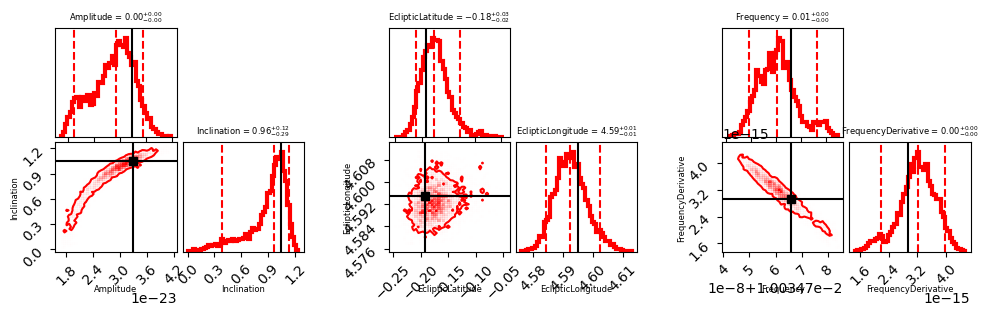

In [60]:
plot_posteriors(i_sub, i_match)